In [1]:
import numpy as np
from urllib.request import urlopen
%matplotlib inline
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston

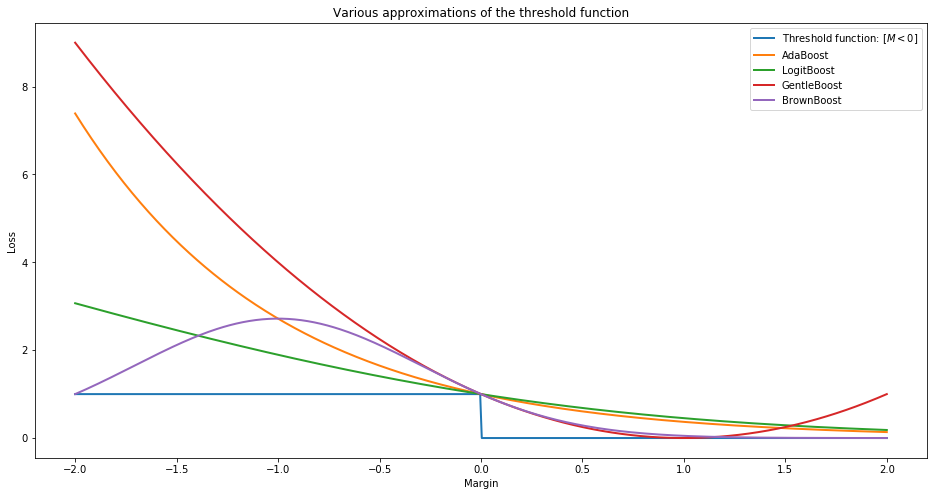

In [4]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(16, 8))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[M < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')
plt.xlabel('Margin')
plt.ylabel('Loss');

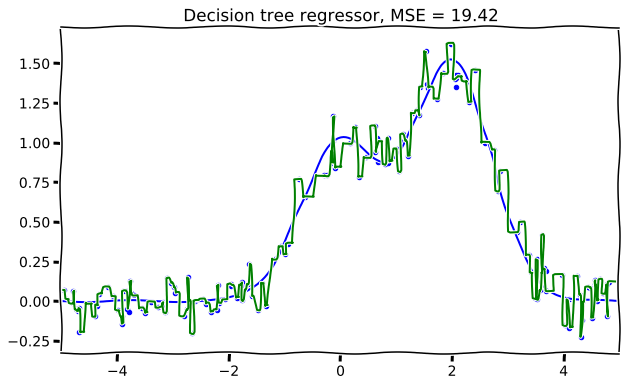

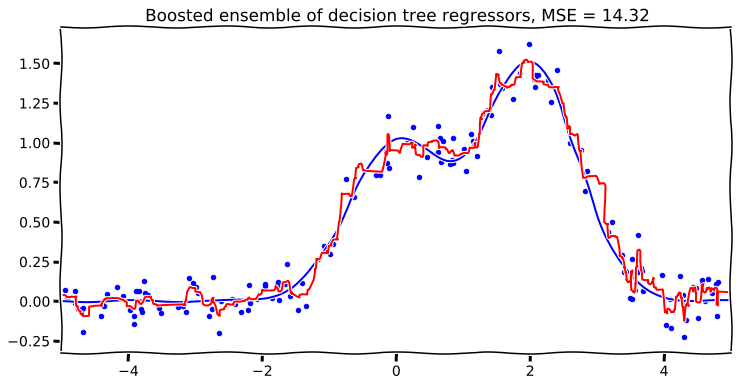

In [6]:
n_train = 150
n_test = 1000
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) +\
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor(random_state=42)

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

with plt.xkcd():
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, d_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("Decision tree regressor, MSE = %.2f" % 
              np.sum((y_test - d_predict) ** 2))

    gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5,
                                       random_state=42)
    gbtree.fit(X_train, y_train)
    gb_predict = gbtree.predict(X_test)

    plt.figure(figsize=(12, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, gb_predict, "r", lw=2)
    plt.xlim([-5, 5])
    plt.title("Boosted ensemble of decision tree regressors, MSE = %.2f" % 
              np.sum((y_test - gb_predict) ** 2));

In [8]:
iris = load_iris()
X = iris['data']
y = iris['target']
kf = KFold(n_splits=5, shuffle=True, random_state=13)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
[[9 0 0]
 [0 9 1]
 [0 2 9]]
[[12  0  0]
 [ 0 10  1]
 [ 0  0  7]]
[[10  0  0]
 [ 0 11  0]
 [ 0  0  9]]


In [9]:
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

8.129992031937604
9.65223163719097
17.839230414021902
6.857900911239092
8.673159469080009


In [11]:
X = boston['data']
y = boston['target']

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6]}, verbose=1, cv=5)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6699572097100618
{'max_depth': 2}


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.6s finished
/home/zark/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.177778
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.157778
[2]	validation_0-merror:0.148889
[3]	validation_0-merror:0.135556
[4]	validation_0-merror:0.131111
[5]	validation_0-merror:0.122222
[6]	validation_0-merror:0.106667
[7]	validation_0-merror:0.104444
[8]	validation_0-merror:0.104444
[9]	validation_0-merror:0.102222
[10]	validation_0-merror:0.097778
[11]	validation_0-merror:0.097778
[12]	validation_0-merror:0.095556
[13]	validation_0-merror:0.095556
[14]	validation_0-merror:0.097778
[15]	validation_0-merror:0.097778
[16]	validation_0-merror:0.093333
[17]	validation_0-merror:0.088889
[18]	validation_0-merror:0.091111
[19]	validation_0-merror:0.093333
[20]	validation_0-merror:0.091111
[21]	validation_0-merror:0.086667
[22]	validation_0-merror:0.084444
[23]	validation_0-merror:0.082222
[24]	validation_0-merror:0.082222
[25]	validation_0-merror:0.082222
[26]	validation_0-merror:0.082222
[27]	validation_0-merror:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

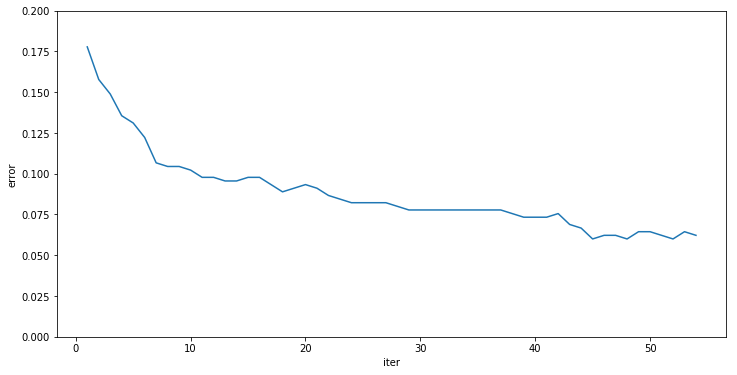

In [13]:
errors_by_iter = clf.evals_result()['validation_0']['merror']
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter)
plt.xlabel('iter');
plt.ylabel('error');
plt.ylim(0, 0.2);